In [2]:
import pandas as pd 
import csv
from builtins import open, bytes
import gensim
from gensim.utils import simple_preprocess
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
nltk.download('stopwords')
from deep_translator import GoogleTranslator
from langdetect import detect
import seaborn as sns
from recordlinkage.standardise import clean
from nltk.sentiment.vader import SentimentIntensityAnalyzer

/Users/chris/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package stopwords to /Users/chris/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## **Helper Functions**

In [3]:
# screen tweets that has geographic locations within United States
import pandas as pd

def filter_us_locations(df, location_column='user/location'):
    # List of state names and abbreviations including territories and major cities
    valid_endings = [
        ' usa', ' alabama', ' alaska', ' arizona', ' arkansas', ' california', 
        ' colorado', ' connecticut', ' delaware', ' florida', ' georgia', 
        ' hawaii', ' idaho', ' illinois', ' indiana', ' iowa', ' kansas', 
        ' kentucky', ' louisiana', ' maine', ' maryland', ' massachusetts', 
        ' michigan', ' minnesota', ' mississippi', ' missouri', ' montana', 
        ' nebraska', ' nevada', ' new hampshire', ' new jersey', ' new mexico', 
        ' new york', ' north carolina', ' north dakota', ' ohio', ' oklahoma', 
        ' oregon', ' pennsylvania', ' rhode island', ' south carolina', 
        ' south dakota', ' tennessee', ' texas', ' utah', ' vermont', ' virginia', 
        ' washington', ' west virginia', ' wisconsin', ' wyoming', ' dc', 
        ' puerto rico', ' guam', ' u.s. virgin islands', ' northern mariana islands',
        ' al', ' ak', ' az', ' ar', ' ca', ' co', ' ct', ' de', ' fl', ' ga', 
        ' hi', ' id', ' il', ' in', ' ia', ' ks', ' ky', ' la', ' me', ' md', 
        ' ma', ' mi', ' mn', ' ms', ' mo', ' mt', ' ne', ' nv', ' nh', ' nj', 
        ' nm', ' ny', ' nc', ' nd', ' oh', ' ok', ' or', ' pa', ' ri', ' sc', 
        ' sd', ' tn', ' tx', ' ut', ' vt', ' va', ' wa', ' wv', ' wi', ' wy', 
        ' dc', ' pr', ' gu', ' vi', ' mp', ' as', 'usa', 'u.s.a', 'united states',
        'america', 'us', 'chicago', 'new york', 'san diego', 'san francisco', 
        'los angeles', 'seattle', 'boston', 'dallas', 'denver', 'oklahoma city', 
        'philadelphia', 'phoenix', 'detroit', 'houston', 'kansas city', 'charlotte', 
        'baltimore', 'dmv', 'springfield', 'las vegas', 'columbus', 'miami', 'atlanta'
    ]
    
    # Function to determine if the location is within the US or the cell is empty
    def is_within_us(location):
        location = location.lower().strip()
        return any(ending in location for ending in valid_endings)

    # Filter the DataFrame
    filtered_df = df[df[location_column].apply(is_within_us)]

    return filtered_df

In [4]:
def clean_and_translate(bp):
    # detect the language of each comments
    from langdetect import detect
    def detect_text(text):
        try:
            return detect(text)
        except: 
            return 'Unknown'

    # create translation function
    from deep_translator import GoogleTranslator
    def translate(text): 
        translator = GoogleTranslator(source = 'auto', target='english')
        translation = translator.translate(text)
        return translation 

    # remove stop words function 
    def remove_stop_words(text): 
        final_text = []
        text = text.lower()
        stop = set(stopwords.words('english'))
        for i in text.split():
            if i.strip() not in stop and i.strip() != 'https':
                final_text.append(i.strip())
        return " ".join(final_text)
    
    # Remove rows where 'user/location' is empty or NaN
    bp = bp.dropna(subset=['user/location'])
    bp = bp[bp['user/location'].str.strip() != '']

    # # clean comments 
    bp['full_text'] = clean(bp['full_text'])

    # remove stop words from each comments 
    bp['full_text'] = bp['full_text'].apply(remove_stop_words)

    # change the data type of the comment 
    bp = bp.astype({'full_text': 'string'})

    # remove http links 
    bp['full_text'] = bp['full_text'].str.replace(r'http\S+', '', regex=True)

    # delete rows with less than 5 character in comments
    bp['length'] = bp['full_text'].str.len()
    drop_lst = bp[bp['length'] < 5].index.to_list()
    bp = bp.drop(drop_lst, axis = 0)
    bp = bp.reset_index()
    
    # create a language column for comment language identifier and make index list for it 
    # bp['language'] = bp['full_text'].apply(detect_text)
    # index_lst = bp[bp['language'] != 'en'].index.to_list()

    # create the translated column
    bp['translated'] = bp['full_text']

    # # apply translation 
    # err_df = bp.iloc[index_lst]
    # err_df['translated'] = err_df['full_text'].apply(translate)

    # update the final data 
    bp = bp.drop(columns='index')
    # bp = bp.drop(columns='Unnamed: 0')

    return bp 

In [5]:
from langdetect import detect
def detect_text(text):
    try:
        return detect(text)
    except: 
        return 'Unknown'

def translate(text): 
    translator = GoogleTranslator(source = 'auto', target='english')
    translation = translator.translate(text)
    return translation 

## Iran

In [21]:
ir = pd.read_csv('/Users/chris/Desktop/Thesis/public_opinion_thesis/Data/iran_cleaned.csv') # read in the data from csv file 
ir.drop(columns=['Unnamed: 0','truncated_full_text'],inplace=True) # drop unnecessary column
ir['full_text'] = ir['full_text'].astype(str)   # transfer text column into string type 
len(ir)

19408

In [22]:
# pre-processing data by removing stop words and filter geo location info
ir_cleaned = clean_and_translate(ir)
len(ir_cleaned)


18603

In [23]:
ir_cleaned = filter_us_locations(ir_cleaned)
len(ir_cleaned)

13519

In [7]:
print(ir_cleaned['year'].value_counts())
print(ir['year'].value_counts())

2023    2489
2022    2438
2021    2304
2020    2153
2019    2147
2018    1988
Name: year, dtype: int64
2021    3577
2023    3516
2022    3480
2020    3086
2019    2968
2018    2781
Name: year, dtype: int64


In [8]:
# identify language of each comments 
ir_cleaned['language'] = ir_cleaned['full_text'].apply(detect_text)
# generating list of comments that are not in English 
index_lst = ir_cleaned[ir_cleaned['language'] != 'en'].index.to_list()
# creating sub_dataframe to store tweets that are not written in English 
ir_need_trans = ir_cleaned.loc[index_lst]

In [14]:
# manually divide the dataframe into several parts
ir_df1 = ir_need_trans[:1000]
ir_df2 = ir_need_trans[1000:2000]
ir_df3 = ir_need_trans[2000:3000]
ir_df4 = ir_need_trans[3000:4000]
ir_df5 = ir_need_trans[4000:]

In [26]:
# implement the translation formula to translate tweets text into English
ir_df1['translated'] = ir_df1['full_text'].apply(translate)
ir_df2['translated'] = ir_df2['full_text'].apply(translate)
ir_df3['translated'] = ir_df3['full_text'].apply(translate)
ir_df4['translated'] = ir_df4['full_text'].apply(translate)
ir_df5['translated'] = ir_df5['full_text'].apply(translate)

/var/folders/nq/5z_sx69s5ngg5p145v4g54t80000gn/T/ipykernel_46797/1876647491.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ir_df1['translated'] = ir_df1['full_text'].apply(translate)
/var/folders/nq/5z_sx69s5ngg5p145v4g54t80000gn/T/ipykernel_46797/1876647491.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ir_df2['translated'] = ir_df2['full_text'].apply(translate)
/var/folders/nq/5z_sx69s5ngg5p145v4g54t80000gn/T/ipykernel_46797/1876647491.py:4: SettingWithCopyWarning: 
A value is trying to be set o

In [27]:
translated_seg = pd.concat([ir_df1, ir_df2, ir_df3, ir_df4, ir_df5])

In [30]:
ir_cleaned.update(translated_seg)
ir_cleaned = ir_cleaned.rename(columns={'full_text':'orig_text'})
ir_cleaned = ir_cleaned.drop(columns='length')
ir_cleaned = ir_cleaned.drop(columns='language')
ir_cleaned['country'] = 'iran'

In [32]:
ir_cleaned.to_csv('/Users/chris/Desktop/Thesis/public_opinion_thesis/Data/iran_translated.csv')

## China

In [15]:
china = pd.read_csv('/Users/chris/Desktop/Thesis/public_opinion_thesis/Data/china_cleaned.csv') # read in the data from csv file 
china.drop(columns=['Unnamed: 0'],inplace=True) # drop unnecessary column
len(china)

18002

In [16]:
# pre-processing data by removing stop words and filter geo location info
china_cleaned = clean_and_translate(china)
len(china_cleaned)

17505

In [17]:
china_cleaned = filter_us_locations(china_cleaned)
len(china_cleaned)

14632

In [ ]:
# identify language of each comments 
china_cleaned['language'] = china_cleaned['full_text'].apply(detect_text)
china_cleaned

In [28]:
china_cleaned[(china_cleaned['year']==2018) & (china_cleaned['month']== "Dec")]

,full_text,url,user_id_str,user/location,month,day,year,length,translated
469,chinese government donates 50 patrol motorcycl...,https://twitter.com/developingpak/status/10757...,748197966968561664,"Islamabad, Pakistan",Dec,20,2018,150,chinese government donates 50 patrol motorcycl...
471,chinese hui muslims supporting brothers uyghur...,https://twitter.com/mufidyuksel/status/1077318...,246575315,"New Jersey, NJ",Dec,24,2018,135,chinese hui muslims supporting brothers uyghur...
472,today fbi director wray joined thejusticedept ...,https://twitter.com/FBI/status/107582721538283...,17629860,"Washington, DC",Dec,20,2018,205,today fbi director wray joined thejusticedept ...
474,chinese government allowfree muslims beliefs p...,https://twitter.com/mufidyuksel/status/1077270...,246575315,"Alaska, AK",Dec,24,2018,200,chinese government allowfree muslims beliefs p...
476,highlight us indicts chinese state hackers con...,https://twitter.com/YahooFinance/status/107579...,19546277,"New York, NY",Dec,20,2018,186,highlight us indicts chinese state hackers con...
...,...,...,...,...,...,...,...,...,...
771,chinese government deliberately sows confusion...,https://twitter.com/samirsaran/status/10790969...,68164273,"Jacksonville, Florida",Dec,29,2018,181,chinese government deliberately sows confusion...
772,way kind thing international bds campaign musl...,https://twitter.com/Mendelpol/status/107677874...,2581849280,us,Dec,23,2018,158,way kind thing international bds campaign musl...
773,hey gerryshih ever asked editors wapo still ac...,https://twitter.com/JunkScience/status/1078652...,21150492,U.S.A,Dec,28,2018,123,hey gerryshih ever asked editors wapo still ac...
774,chinese scientist jiankui claimed last month s...,https://twitter.com/axios/status/1079031788310...,800707492346925056,"Oklahoma City, Oklahoma",Dec,29,2018,160,chinese scientist jiankui claimed last month s...


In [48]:
# generating list of comments that are not in English 
index_lst = china_cleaned[china_cleaned['language'] != 'en'].index.to_list()
# creating sub_dataframe to store tweets that are not written in English 
china_need_trans = china_cleaned.loc[index_lst]

In [14]:
china_need_trans.count()

full_text        2463
url              2463
user_id_str      2463
user/location    2463
month            2463
day              2463
year             2463
length           2463
translated       2463
language         2463
dtype: int64

In [15]:
# manually divide the dataframe into several parts
china_df1 = china_need_trans[:700]
china_df2 = china_need_trans[700:1400]
china_df3 = china_need_trans[1400:2100]
china_df4 = china_need_trans[2100:]

In [16]:
# implement the translation formula to translate tweets text into English
china_df1['translated'] = china_df1['full_text'].apply(translate)
china_df2['translated'] = china_df2['full_text'].apply(translate)
china_df3['translated'] = china_df3['full_text'].apply(translate)
china_df4['translated'] = china_df4['full_text'].apply(translate)

/var/folders/nq/5z_sx69s5ngg5p145v4g54t80000gn/T/ipykernel_13885/1277191382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  china_df1['translated'] = china_df1['full_text'].apply(translate)
/var/folders/nq/5z_sx69s5ngg5p145v4g54t80000gn/T/ipykernel_13885/1277191382.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  china_df2['translated'] = china_df2['full_text'].apply(translate)
/var/folders/nq/5z_sx69s5ngg5p145v4g54t80000gn/T/ipykernel_13885/1277191382.py:4: SettingWithCopyWarning: 
A value is trying

In [63]:
translated_seg = pd.concat([china_df1, china_df2, china_df3, china_df4])

In [64]:
china_cleaned.update(translated_seg)

In [65]:
china_cleaned.count()

full_text        14632
url              14632
user_id_str      14632
user/location    14632
month            14632
day              14632
year             14632
length           14632
translated       14632
language         14632
dtype: int64

In [66]:
china_cleaned = china_cleaned.rename(columns={'full_text':'orig_text'})
china_cleaned = china_cleaned.drop(columns=['length'])
china_cleaned = china_cleaned.drop(columns=['language'])
china_cleaned['country'] = 'china'

In [67]:
china_cleaned[china_cleaned['year']==2018]['month'].value_counts()

Dec    254
Jun    253
Oct    236
Sep    232
Jul    227
Nov    222
Mar    221
Feb    215
May    212
Apr    203
Jan    189
Aug    186
Name: month, dtype: int64

In [70]:
china_cleaned.to_csv('/Users/chris/Desktop/Thesis/public_opinion_thesis/Data/china_translated.csv')

## Russia

In [18]:
ru = pd.read_csv('/Users/chris/Desktop/Thesis/public_opinion_thesis/Data/russia_cleaned.csv') # read in the data from csv file 
# ru.drop(columns=['Unnamed: 0','truncated_full_text'],inplace=True) # drop unnecessary column
ru['full_text'] = ru['full_text'].astype(str)   # transfer text column into string type 
len(ru)

17165

In [19]:
# pre-processing data by removing stop words and filter geo location info
ru_cleaned = clean_and_translate(ru)
len(ru_cleaned)

14931

In [20]:
ru_cleaned = filter_us_locations(ru_cleaned)
len(ru_cleaned)

12635

In [22]:
ru_cleaned[ru_cleaned['year'] == 2018]['month'].value_counts()

Feb    231
Jul    207
Oct    207
Jan    204
Mar    203
Aug    193
May    190
Dec    188
Apr    173
Nov    173
Jun    168
Sep    123
Name: month, dtype: int64

In [23]:
# identify language of each comments 
ru_cleaned['language'] = ru_cleaned['full_text'].apply(detect_text)
# generating list of comments that are not in English 
index_lst = ru_cleaned[ru_cleaned['language'] != 'en'].index.to_list()
# creating sub_dataframe to store tweets that are not written in English 
ru_need_trans = ru_cleaned.loc[index_lst]

In [24]:
# manually divide the dataframe into several parts
ru_df1 = ru_need_trans[:100]
ru_df2 = ru_need_trans[100:200]
ru_df3 = ru_need_trans[200:300]
ru_df4 = ru_need_trans[300:400]
ru_df5 = ru_need_trans[400:]

In [25]:
# implement the translation formula to translate tweets text into English
ru_df1['translated'] = ru_df1['full_text'].apply(translate)
ru_df2['translated'] = ru_df2['full_text'].apply(translate)
ru_df3['translated'] = ru_df3['full_text'].apply(translate)
ru_df4['translated'] = ru_df4['full_text'].apply(translate)
ru_df5['translated'] = ru_df5['full_text'].apply(translate)

/var/folders/nq/5z_sx69s5ngg5p145v4g54t80000gn/T/ipykernel_46797/98464560.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ru_df1['translated'] = ru_df1['full_text'].apply(translate)
/var/folders/nq/5z_sx69s5ngg5p145v4g54t80000gn/T/ipykernel_46797/98464560.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ru_df2['translated'] = ru_df2['full_text'].apply(translate)
/var/folders/nq/5z_sx69s5ngg5p145v4g54t80000gn/T/ipykernel_46797/98464560.py:4: SettingWithCopyWarning: 
A value is trying to be set on a co

In [45]:
translated_seg = pd.concat([ru_df1, ru_df2, ru_df3, ru_df4, ru_df5])
ru_cleaned.update(translated_seg)
ru_cleaned = ru_cleaned.rename(columns={'full_text':'orig_text'})
ru_cleaned = ru_cleaned.drop(columns='length')
ru_cleaned = ru_cleaned.drop(columns='language')
ru_cleaned['country'] = 'russia'

In [49]:
ru_cleaned.to_csv('/Users/chris/Desktop/Thesis/public_opinion_thesis/Data/russia_translated.csv')

## North Korean

In [6]:
nk = pd.read_csv('/Users/chris/Desktop/Thesis/public_opinion_thesis/Data/nk_cleaned.csv') # read in the data from csv file 
nk['full_text'] = nk['full_text'].astype(str)   # transfer text column into string type 

In [7]:
len(nk)

15023

In [8]:
# pre-processing data by removing stop words and filter geo location info
nk_cleaned = clean_and_translate(nk)
len(nk_cleaned)

14524

In [9]:
nk_cleaned = filter_us_locations(nk_cleaned)
len(nk_cleaned)

12032

In [18]:
# identify language of each comments 
nk_cleaned['language'] = nk_cleaned['full_text'].apply(detect_text)
# generating list of comments that are not in English 
index_lst = nk_cleaned[nk_cleaned['language'] != 'en'].index.to_list()
# creating sub_dataframe to store tweets that are not written in English 
nk_need_trans = nk_cleaned.loc[index_lst]

In [19]:
len(index_lst)

280

In [19]:
# manually divide the dataframe into several parts
nk_df1 = nk_need_trans[:1000]

In [20]:
# implement the translation formula to translate tweets text into English
nk_df1['translated'] = nk_df1['full_text'].apply(translate)

In [21]:
nk_cleaned.update(nk_df1)
nk_cleaned = nk_cleaned.rename(columns={'full_text':'orig_text'})
nk_cleaned = nk_cleaned.drop(columns='length')
nk_cleaned = nk_cleaned.drop(columns='language')
nk_cleaned['country'] = 'nk'

In [22]:
nk_cleaned.to_csv('/Users/chris/Desktop/Thesis/public_opinion_thesis/Data/nk_translated.csv')

## Summary

In [12]:
nk0 = pd.read_csv('/Users/chris/Desktop/Thesis/public_opinion_thesis/Data/nk_cleaned.csv')
iran0 = pd.read_csv('/Users/chris/Desktop/Thesis/public_opinion_thesis/Data/iran_cleaned.csv')
china0 = pd.read_csv('/Users/chris/Desktop/Thesis/public_opinion_thesis/Data/china_cleaned.csv')
russia0 = pd.read_csv('/Users/chris/Desktop/Thesis/public_opinion_thesis/Data/russia_cleaned.csv')

In [10]:
nk = pd.read_csv('/Users/chris/Desktop/Thesis/public_opinion_thesis/Data/nk_translated.csv')
iran = pd.read_csv('/Users/chris/Desktop/Thesis/public_opinion_thesis/Data/iran_translated.csv')
china = pd.read_csv('/Users/chris/Desktop/Thesis/public_opinion_thesis/Data/china_translated.csv')
russia = pd.read_csv('/Users/chris/Desktop/Thesis/public_opinion_thesis/Data/russia_translated.csv')

In [13]:
print('iran after cleaning', len(iran))
print('iran before cleaning', len(iran0))

print('nk after cleaning', len(nk))
print('nk before cleaning', len(nk0))

print('china after cleaning', len(china))
print('china before cleaning', len(china0))

print('russia after cleaning', len(russia))
print('russia before cleaning', len(russia0))


iran after cleaning 13519
iran before cleaning 19408
nk after cleaning 12032
nk before cleaning 15023
china after cleaning 14632
china before cleaning 18002
russia after cleaning 12635
russia before cleaning 17165


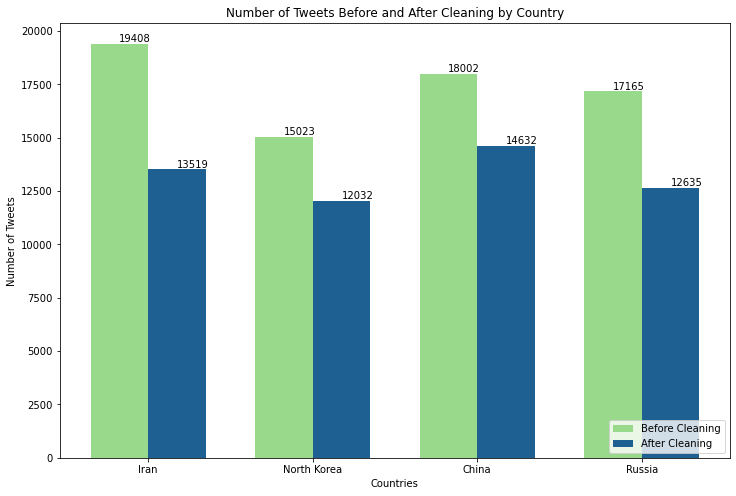

In [9]:
import matplotlib.pyplot as plt

# Data setup
countries = ['Iran', 'North Korea', 'China', 'Russia']
before_cleaning = [19408, 15023, 18002, 17165]
after_cleaning = [13519, 12032, 14632, 12635]
x = range(len(countries))

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))  # Smaller figure size
bar_width = 0.35

bars1 = ax.bar(x, before_cleaning, width=bar_width, label='Before Cleaning', color='#99d98c')
bars2 = ax.bar([p + bar_width for p in x], after_cleaning, width=bar_width, label='After Cleaning', color='#1e6091')

# Adding annotations
for bar in bars1:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom')  # va: vertical alignment

for bar in bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom')  # va: vertical alignment

# Labeling
ax.set_xlabel('Countries')
ax.set_ylabel('Number of Tweets')
ax.set_title('Number of Tweets Before and After Cleaning by Country')
ax.set_xticks([p + bar_width / 2 for p in x])
ax.set_xticklabels(countries)
ax.legend(loc='lower right')

plt.show()
